# Exploratory Analysis and Feature Engineering

## Datasets used

Direct marketing, [Data Set](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

Tips [Data Set](https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv) provided on Seaborn site.

In this notebook we will learn Exploratory Data Analysis and Feature Engineering by leveraging above two data sets.

#### Goal of the lab is to introduce you to all the tools and techniques used for Exploratory Data Analysis and Feature Engineering but these techniques may not be comprehensive.

Here are some high level steps.

* Download and Load Datasets into Pandas DataFrame.
* Understand some common libraries used to work with the data and to plot
* Types of plots used in Exploratory Data Analysis and how to plot using Pandas as well as Seaborn
* Some trivial Data Cleaning process as an motivation examples.
* Investigating and transforming (Feature Engineering) the data so that it can be fed to algorithms

---

## Preparation


Let's start by specifying:

- The S3 bucket and prefix that you want to use for hosting the data.
- The IAM role  used to give access to your data.

In [3]:
# Import boto and sagemaker liraries
import boto3
import re
import sagemaker
from sagemaker import get_execution_role

session=sagemaker.Session()

bucket = session.default_bucket()

prefix = 'sagemaker/DEMO-xgboost-dm-10192020'

role = get_execution_role()

Now let's bring in the Python libraries that we'll use throughout the analysis

In [4]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sklearn

import seaborn as sns
sns.set_style('white')                            #Set theme for Seaborn
import matplotlib.pyplot as plt                   # For charts and visualizations
import sys                                        # For writing outputs to notebook
import os                                         # For manipulating filepath names
%matplotlib inline                               

---

## Data 
Let's start by downloading the [direct marketing dataset](https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip) from the sample data s3 bucket. 

\[Moro et al., 2014\] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014


In [6]:
!wget https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
!apt-get install unzip -y
!unzip -o bank-additional.zip
!head './bank-additional/bank-additional-full.csv'

--2020-10-19 17:07:50--  https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
Resolving sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)... 52.218.246.153
Connecting to sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)|52.218.246.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432828 (423K) [application/zip]
Saving to: ‘bank-additional.zip.8’

bank-additional.zip 100%[===================>] 422.68K  --.-KB/s    in 0.01s   

2020-10-19 17:07:50 (34.8 MB/s) - ‘bank-additional.zip.8’ saved [432828/432828]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-23+deb10u1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Archive:  bank-additional.zip
  inflating: ban

## Exploration

#### Read the data into a Pandas DataFrame to explore.

In [8]:
data = pd.read_csv('./bank-additional/bank-additional-full.csv') # Other arguments you can pass sep='\t', header, names
pd.set_option('display.max_columns', 50)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20) 



In [9]:
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### Pandas DataFrame and Series

In [10]:
df2=pd.DataFrame({'num':[1,2,4,5], 'alpha':['a','b','c','d']}, index=['g1','g2','g3','g4'])
df2

,num,alpha
g1,1,a
g2,2,b
g3,4,c
g4,5,d


In [11]:
type(df2)

pandas.core.frame.DataFrame

In [13]:
ser=df2['alpha'] # You can also add  your own index to Series as well
ser

g1    a
g2    b
g3    c
g4    d
Name: alpha, dtype: object

In [14]:
type(ser)

pandas.core.series.Series

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [16]:
data.dtypes.groupby(data.dtypes).size() # Try sorting by max type

int64       5
float64     5
object     11
dtype: int64

In [17]:
data.shape

(41188, 21)

In [18]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [19]:
data.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,239,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


### At a high level, we can see:

* We have a little over 40K customer records, and 20 features for each customer
* The features are mixed; some numeric, some categorical

_**Lets understand Specifics on each of the features which helps us further in the process:**_

*Demographics:*
* `age`: Customer's age (numeric)
* `job`: Type of job (categorical: 'admin.', 'services', ...)
* `marital`: Marital status (categorical: 'married', 'single', ...)
* `education`: Level of education (categorical: 'basic.4y', 'high.school', ...)

*Past customer events:*
* `default`: Has credit in default? (categorical: 'no', 'unknown', ...)
* `housing`: Has housing loan? (categorical: 'no', 'yes', ...)
* `loan`: Has personal loan? (categorical: 'no', 'yes', ...)

*Past direct marketing contacts:*
* `contact`: Contact communication type (categorical: 'cellular', 'telephone', ...)
* `month`: Last contact month of year (categorical: 'may', 'nov', ...)
* `day_of_week`: Last contact day of the week (categorical: 'mon', 'fri', ...)
* `duration`: Last contact duration, in seconds (numeric). Important note: If duration = 0 then `y` = 'no'.
 
*Campaign information:*
* `campaign`: Number of contacts performed during this campaign and for this client (numeric, includes last contact)
* `pdays`: Number of days that passed by after the client was last contacted from a previous campaign (numeric)
* `previous`: Number of contacts performed before this campaign and for this client (numeric)
* `poutcome`: Outcome of the previous marketing campaign (categorical: 'nonexistent','success', ...)

*External environment factors or socio economic factors:*
* `emp.var.rate`: Employment variation rate - quarterly indicator (numeric)
* `cons.price.idx`: Consumer price index - monthly indicator (numeric)
* `cons.conf.idx`: Consumer confidence index - monthly indicator (numeric)
* `euribor3m`: Euribor 3 month rate - daily indicator (numeric)
* `nr.employed`: Number of employees - quarterly indicator (numeric)

*Target variable:*
* `y`: Has the client subscribed a term deposit? (binary: 'yes','no')

### Plotting
#### Lets download tips data to demonstrate some plotting mechanisms.


In [20]:
url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv'
tips = pd.read_csv(url)
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


#### Tools used for plotting
    Matplotlib
    Seaborn
    Pandas builtin plotting
    

#### Type of the plot depends on the analysis we are trying to do
    1. Univeriate : Used to analyse a single feature
    2. Bivariate: Used to analyse two features and their relationships
    3. Multivariate: Used to analyse multiple variables and their relatiosnships.

### Types of plots typically used for data exploration
   #### Bar Chart, Stacked Bar Chart (Bivariate)
    
        The bar chart displays data using a number of bars, each representing a particular category. The height of each bar is proportional to a specific aggregation (for example the sum of the values in the category it represents).

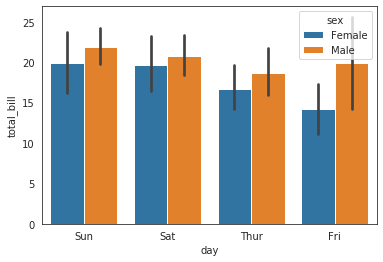

In [21]:
sns.barplot(x='day', y='total_bill', data=tips, hue='sex', orient='v') # use orient to change the orientation

#### Histogram or Distribution plot (Univariate)
        
        It is similar to a Bar Chart, but a histogram groups numbers into ranges and it is used to show a single variable. The height of each bar shows how many fall into each range.
    
    

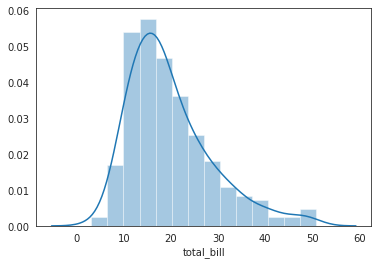

In [22]:
sns.distplot(tips.total_bill) # Use bins to control the intervals

#### Box Plot, Violin Plot (Univariate)
        
    Used to get more statistical details about the data.
            
    

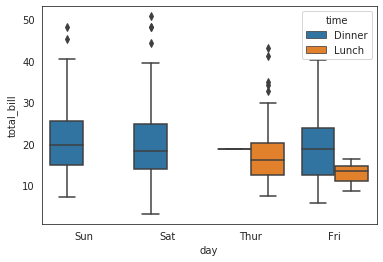

In [23]:
sns.boxplot(x = "day", y = "total_bill", hue = "time", data = tips);

#### Scatter Plot Matrix (Multivariate)
    Is used to understand the relationshop between multiple variables at the same time, it can be used to further dive into 2 variables using scatter plot of those 2 variables
  

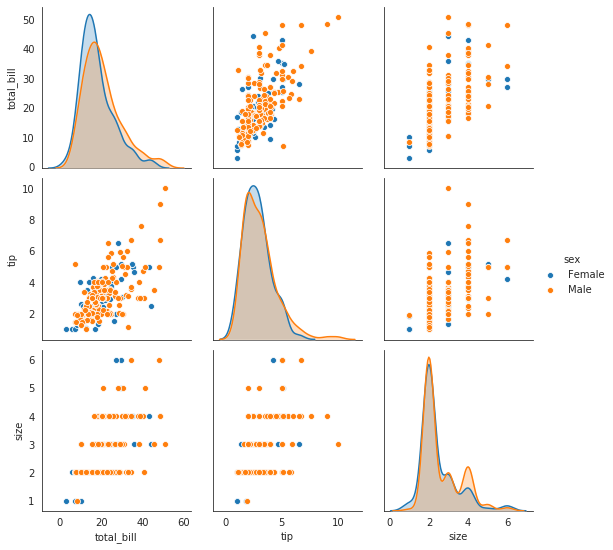

In [24]:
sns.pairplot(tips, hue='sex') # use hue to differentiate between various categorical variables

#### Scatter Plot (Bivariate)
    Shows the relationship between two sets of data

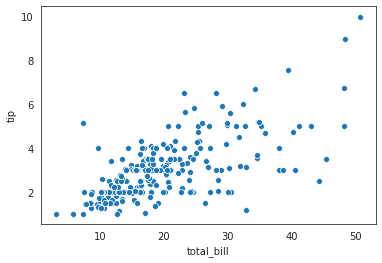

In [25]:
sns.scatterplot(data=tips, x='total_bill', y='tip')

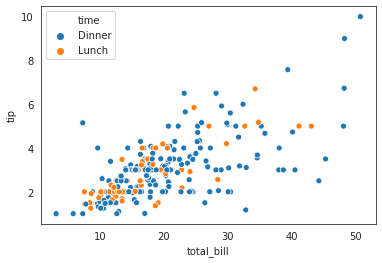

In [27]:
sns.scatterplot(data=tips,x='total_bill', y='tip', hue='time') #Check how it looks for different hue such as day, sex etc. 

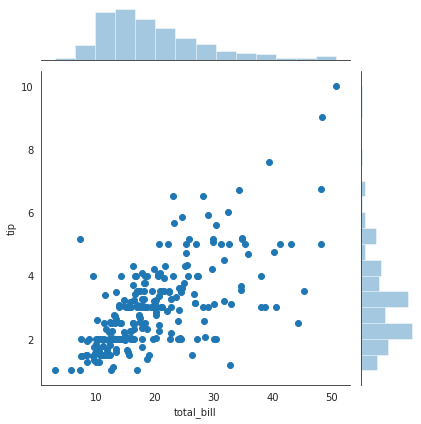

In [28]:
sns.jointplot(data=tips,x='total_bill', y='tip')

#### Correlation Matrix (Multivariate)

    Used to measure how the values are correlated, 1.0 represents hightlly correlated and 
    -1.0 represents least correlated

In [29]:
tips.corr()

,total_bill,tip,size
total_bill,1.000000,0.675734,0.598315
tip,0.675734,1.000000,0.489299
size,0.598315,0.489299,1.000000


#### Heatmap (Multivariate)
    Used to compare any 2 variables with respective to the values

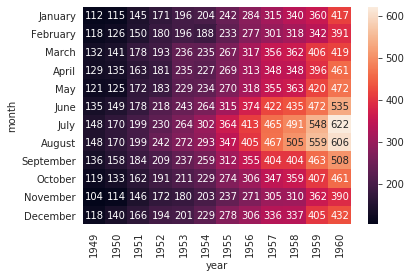

In [30]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights,annot=True, fmt="d")

### Back to Direct Marketing Data Exploration
Understanding how the features are distributed.

Lets build frequency tables for each categorical feature. We can also use bar plot or histogram of each categorical feature variable to understand the distribution easily

col_0,% observations
job,
admin.,0.253035
blue-collar,0.224677
entrepreneur,0.035350
housemaid,0.025736
management,0.070992
retired,0.041760
self-employed,0.034500
services,0.096363
student,0.021244


col_0,% observations
marital,
divorced,0.111974
married,0.605225
single,0.280859
unknown,0.001942


col_0,% observations
education,
basic.4y,0.101389
basic.6y,0.055647
basic.9y,0.146766
high.school,0.231014
illiterate,0.000437
professional.course,0.127294
university.degree,0.295426
unknown,0.042027


col_0,% observations
default,
no,0.791201
unknown,0.208726
yes,0.000073


col_0,% observations
housing,
no,0.452122
unknown,0.024036
yes,0.523842


col_0,% observations
loan,
no,0.824269
unknown,0.024036
yes,0.151695


col_0,% observations
contact,
cellular,0.634748
telephone,0.365252


col_0,% observations
month,
apr,0.063902
aug,0.149995
dec,0.004419
jul,0.174177
jun,0.129115
mar,0.013256
may,0.334296
nov,0.099568
oct,0.017432


col_0,% observations
day_of_week,
fri,0.190031
mon,0.206711
thu,0.209357
tue,0.196416
wed,0.197485


col_0,% observations
poutcome,
failure,0.103234
nonexistent,0.863431
success,0.033335


col_0,% observations
y,
no,0.887346
yes,0.112654


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


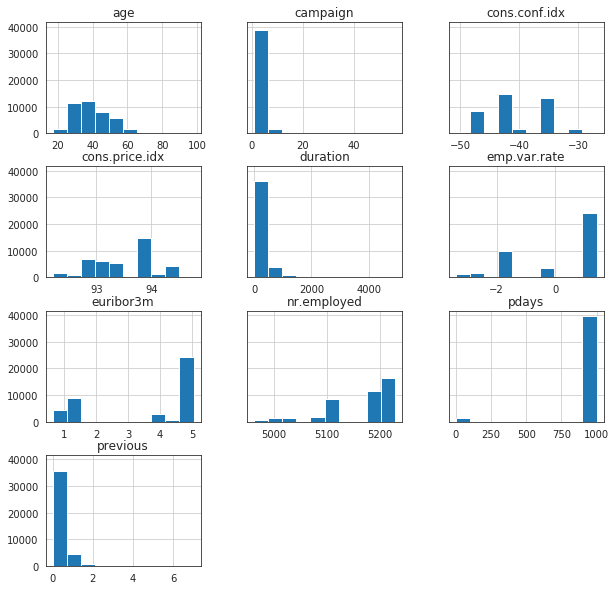

In [31]:
#Frequency tables for each categorical features
# Pandas crosstab  builds a cross-tabulation table that can show the frequency with which certain gorups of data appear.

# Frequency tables for each categorical feature
for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(data.describe())
hist = data.hist(bins=10, sharey=True, figsize=(10, 10))

Notice that:

* Almost 90% of the values for our target variable `y` are "no", so most customers did not subscribe to a term deposit.
* Many of the predictive features take on values of "unknown". 
* Many of the predictive features have categories with very few observations in them.  If we find a small category to be highly predictive of our target outcome, do we have enough evidence to make a generalization about that?
* Contact timing is particularly skewed.  Almost a third in May and less than 1% in December.  What does this mean for predicting our target variable next December?
* There are no missing values in our numeric features.  Or missing values have already been imputed.
  * `pdays` takes a value near 1000 for almost all customers.  Likely a placeholder value signifying no previous contact.
* Several numeric features have a very long tail.  Do we need to handle these few observations with extremely large values differently?
* Several numeric features (particularly the macroeconomic ones) occur in distinct buckets.  Should these be treated as categorical?

Next, let's look at how our features relate to the target that we are attempting to predict.

y,no,yes
job,,
admin.,0.248167,0.291379
blue-collar,0.235745,0.137500
entrepreneur,0.036445,0.026724
housemaid,0.026103,0.022845
management,0.071030,0.070690
retired,0.035187,0.093534
self-employed,0.034804,0.032112
services,0.099759,0.069612
student,0.016417,0.059267


y,no,yes
marital,,
divorced,0.113166,0.102586
married,0.612783,0.545690
single,0.272190,0.349138
unknown,0.001861,0.002586


y,no,yes
education,,
basic.4y,0.102550,0.092241
basic.6y,0.057568,0.040517
basic.9y,0.152457,0.101940
high.school,0.232133,0.222198
illiterate,0.000383,0.000862
professional.course,0.127175,0.128233
university.degree,0.287239,0.359914
unknown,0.040495,0.054095


y,no,yes
default,,
no,0.776814,0.904526
unknown,0.223104,0.095474
yes,0.000082,0.000000


y,no,yes
housing,,
no,0.454088,0.436638
unknown,0.024160,0.023060
yes,0.521752,0.540302


y,no,yes
loan,,
no,0.823574,0.829741
unknown,0.024160,0.023060
yes,0.152266,0.147198


y,no,yes
contact,,
cellular,0.60991,0.830388
telephone,0.39009,0.169612


y,no,yes
month,,
apr,0.057267,0.116164
aug,0.151116,0.141164
dec,0.002545,0.019181
jul,0.178532,0.139871
jun,0.130212,0.120474
mar,0.007388,0.059483
may,0.352495,0.190948
nov,0.100826,0.089655
oct,0.011027,0.067888


y,no,yes
day_of_week,,
fri,0.191009,0.182328
mon,0.209779,0.182543
thu,0.207344,0.225216
tue,0.195277,0.205388
wed,0.196591,0.204526


y,no,yes
poutcome,,
failure,0.099787,0.130388
nonexistent,0.887107,0.676940
success,0.013106,0.192672


age


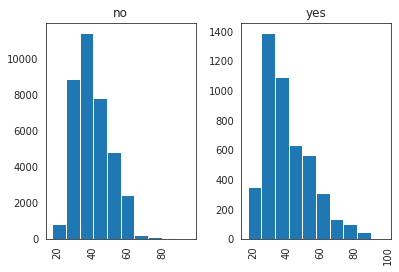

duration


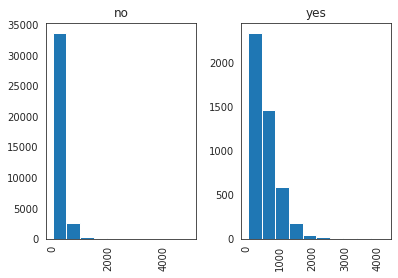

campaign


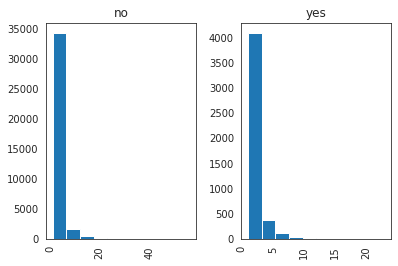

pdays


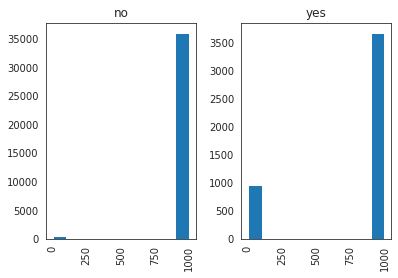

previous


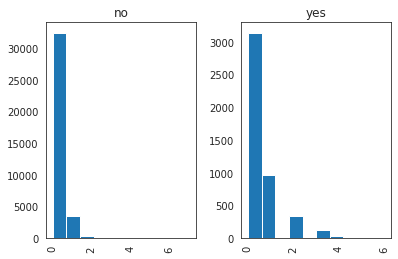

emp.var.rate


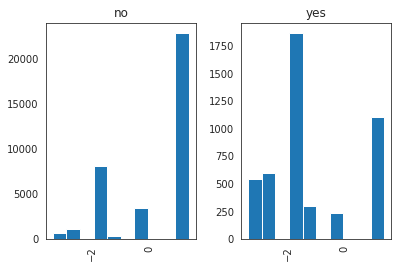

cons.price.idx


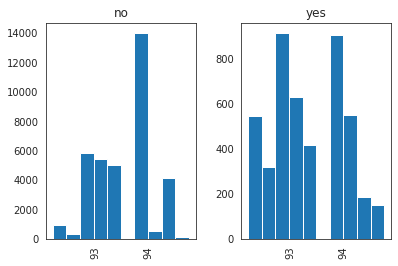

cons.conf.idx


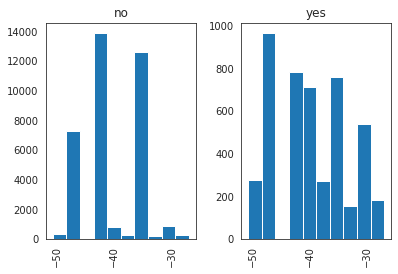

euribor3m


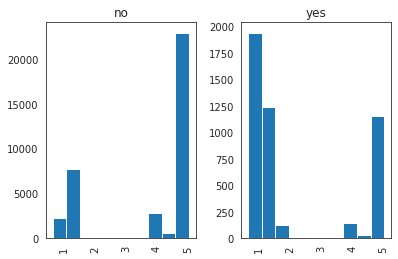

nr.employed


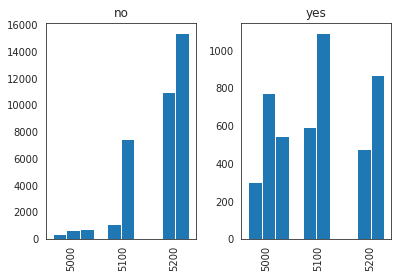

In [32]:
for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':
        display(pd.crosstab(index=data[column], columns=data['y'], normalize='columns'))

for column in data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = data[[column, 'y']].hist(by='y', bins=10)
    plt.show()

Notice that:

* Customers who are-- "blue-collar", "married", "unknown" default status, contacted by "telephone", and/or in "may" are a substantially lower portion of "yes" than "no" for subscribing.
* Distributions for numeric variables are different across "yes" and "no" subscribing groups, but the relationships may not be straightforward or obvious.

Now let's look at how our features relate to one another.

In [33]:
display(data.corr())
data.corr().style.background_gradient(cmap ='Greens').set_properties(**{'font-size': '10px'})

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


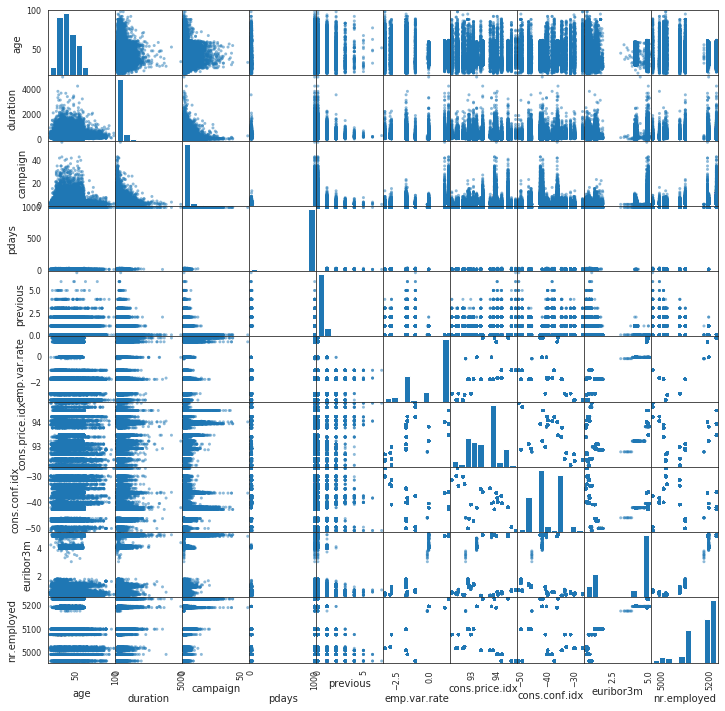

In [34]:
pd.plotting.scatter_matrix(data, figsize=(12, 12))
plt.show()


Notice that:
* Features vary widely in their relationship with one another.  Some with highly negative correlation, others with highly positive correlation.
* Relationships between features is non-linear and discrete in many cases.

### Data Cleaning, Preparation and Feature Engineering
#### Our models are only as good as our data

#### Some Reasons for messy data:
    1. Corrupt Data
    2. Data Load process failure
    3. Noisy and inconsistent data

Cleaning up data is part of nearly every machine learning project.  It arguably presents the biggest risk if done incorrectly and is one of the more subjective aspects in the process.  Several common techniques include:

* Converting categorical to numeric: The most common method is one hot encoding, which for each feature maps every distinct value of that column to its own feature which takes a value of 1 when the categorical feature is equal to that value, and 0 otherwise.



### Handling Missing Data
#### Any missing values in Numerical or categorical features?
#### Ways to handle Missing Data
    1. Drop the columns or rows
    2. Numeric Imputation
    3. Categorical Imputation
Lets get our Categorical and Numeric data

In [36]:
dtypes = pd.DataFrame(data.dtypes.rename('type')).reset_index().astype('str')
# Exclude duration since it is a leaky variable
dtypes = dtypes.query('index != "duration"')
numeric = dtypes[(dtypes.type.isin(['int64', 'float64'])) & (dtypes['index'] != 'duration')]['index'].values
categorical = dtypes[~(dtypes['index'].isin(numeric)) & (dtypes['index'] != 'y')]['index'].values

print('Numeric:\n', numeric)
print('Categorical:\n', categorical)

Numeric:
 ['age' 'campaign' 'pdays' 'previous' 'emp.var.rate' 'cons.price.idx'
 'cons.conf.idx' 'euribor3m' 'nr.employed']
Categorical:
 ['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'day_of_week' 'poutcome']


In [37]:
#Check if there are any null values in categorical variables
data[categorical].isnull().sum()

job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
poutcome       0
dtype: int64

In [38]:
#Check if there are any null values in numeric variables
data[numeric].isnull().sum()

age               0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
dtype: int64

Do not see any misisng values, may be its taken care already by dataset authors. 


We do not have any missing values but here is how we might work with the missing data based on the threshold of missing columns or rows

In [39]:
threshold = 0.9
#Dropping columns with missing value rate greater than threshold
data = data[data.columns[data.isnull().mean() < threshold]]
#Dropping rows with missing value rate higher than threshold
data = data.loc[data.isnull().mean(axis=1) < threshold]
data.shape[0]

41188

You see that the number of rows remained the same which shows none of the columns or rows are missing any data

#### Numeric imputation

Fill with a zero or a median is a general technique for handlong missing numerical values

In [40]:
#Filling all missing values with 0
data = data.fillna(0)
#Filling missing values with medians of the columns
data = data.fillna(data.median())


#### Categorical Imputation

Fill with NA or UNKNOWN or Other is a common technique to take missingness into account but sometimes we can also replace missing values with the value that occurs the most. I think our current data set repalced missing values with unknown.

In [41]:
#Max fill function for categorical columns
data['education'].fillna(data['education'].value_counts().idxmax(), inplace=True)
data.shape

(41188, 21)

### Eliminate duplicates

In [42]:
data.shape

(41188, 21)

In [43]:
data=data.drop_duplicates()
data.shape

(41176, 21)

In [44]:
data.shape

(41176, 21)

### Handling Outliers
    1. Standard deviation technique
    2. Percentiles

#### Standard deviation technique

Dropping the outlier rows with standard deviation

In [45]:

multiplier = 1.5
for column in ['age','campaign','pdays']:
    upper_lim = data[column].mean() + data[column].std () * multiplier
    lower_lim = data[column].mean() - data[column].std () * multiplier
    data = data[(data[column] < upper_lim) & (data[column] > lower_lim)]
data.shape

(33285, 21)

Percentiles technique for handling outliers

In [46]:
for column in ['age','campaign','pdays']:
    upper_lim = data[column].quantile(.97)
    lower_lim = data[column].quantile(.10)
    #data = data[(data[column] < upper_lim)]
data.shape

(33285, 21)

### Feature Engineering Techniques

Feature engineering techniques are important as our models expect the data in a certain way.
 For ex: Linear Models expect that the relation between the input and output is linear, a common technique to convert non-linear to linear relation is to apply the log on the variable.
 
#### Decompose or Aggregate Attributes

In [47]:
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)                                 # Indicator variable to capture when pdays takes a value of 999
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)   # Indicator for individuals not actively employed


#### Variable Transformation 
    1. Logarthematic transformation
    
    2. Ecoding Categorical Features
    
        Nominal: Red, Blue, Gree, True , False
        
            Binary Encoding
            One Hot Encoding
            
        Ordinal: Low, Medium, High
        
            Ordina Encoding: 0, 1, 2     
        
    3. Scaling
        
            Standard Scaling: (var - mean)/standard error
            Min-Max Scaling: Coverts all the variables to range of 0 and 1.
            Robust Scaling: Takes ranges outside of 0 and 1 as it maps 0 to interquartile range of 25 and 1 ot 75.
            
    

### One Hot Encoding

In [48]:
model_data = pd.get_dummies(data)  # Convert categorical variables to sets of indicators
model_data

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,...,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,y_no,y_yes
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0
5,45,198,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0
7,41,217,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0
9,25,50,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41176,38,360,1,999,0,-1.1,94.767,-50.8,1.031,4963.6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0
41180,36,254,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0
41181,37,281,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0


In [49]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

scaled_df=StandardScaler(model_data)
scaled_df

StandardScaler(copy=       age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
2       37       226         1    999         0           1.1          93.994   
3       40       151         1    999         0           1.1          93.994   
5       45       198         1    999         0           1.1          93.994   
7       41       217         1    999         0           1.1          93.994   
9       25        50         1    999         0           1.1          93.994   
...    ...       ...       ...    ...       ...           ...             ...   
41176   38       360         1    999         0          -1.1          94.767   
41180   36       254         2    999         0          -1.1          94.767   
41181   37       281         1    999         0          -1.1          94.767   
41184   46       383         1    999         0          -1.1          94.767   
41186   44       442         1    999         0          -1.1          94.767   

       

In [50]:
scaled_df2=RobustScaler(model_data)
scaled_df2

RobustScaler(copy=True, quantile_range=(25.0, 75.0),
             with_centering=       age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
2       37       226         1    999         0           1.1          93.994   
3       40       151         1    999         0           1.1          93.994   
5       45       198         1    999         0           1.1          93.994   
7       41       217         1    999         0           1.1          93.994   
9       25        50         1    999         0           1.1          93.994   
...    ...       ...       ...    ...       ...           ...             ...   
41176   38       360         1    999         0          -1.1          94.767   
41180   36       254         2    999         0          -1.1          94.767   
41181   37       281         1    999         0          -1.1          94.767   
41184   46       383         1    999         0          -1.1          94.767   
411...
       month_sep  day

In [51]:
scaled_df3=MinMaxScaler(model_data)
scaled_df3

MinMaxScaler(copy=True,
             feature_range=       age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
2       37       226         1    999         0           1.1          93.994   
3       40       151         1    999         0           1.1          93.994   
5       45       198         1    999         0           1.1          93.994   
7       41       217         1    999         0           1.1          93.994   
9       25        50         1    999         0           1.1          93.994   
...    ...       ...       ...    ...       ...           ...             ...   
41176   38       360         1    999         0          -1.1          94.767   
41180   36       254         2    999         0          -1.1          94.767   
41181   37       281         1    999         0          -1.1          94.767   
41184   46       383         1    999         0          -1.1          94.767   
41186   44       442         1    999         0          -

#### Variable selection technique

In [52]:
model_data = model_data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)